# Import Necessary Libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')


In [3]:
dataset = pd.read_csv("nearest-earth-objects(1910-2024).csv")
df = dataset.copy() 
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [4]:
df.columns

Index(['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance', 'is_hazardous'],
      dtype='object')

# Data Cleaning 

In [5]:
# check for missing values in each columns
print(df.isnull().sum())

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64


In [6]:
# Handle Missing Values
null_columns_names = ['absolute_magnitude' , 'estimated_diameter_min','estimated_diameter_max']
for col in null_columns_names :
    mean = (df[col].mean())
    df.fillna({col : 'mean'} , inplace = True)
df.isnull().sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
# drop columns with one unique values
df = df.drop(['orbiting_body'] , axis = 1)

In [9]:
df

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.5,0.530341,1.185878,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.7,0.076658,0.171412,56036.519484,6.311863e+07,False
...,...,...,...,...,...,...,...,...
338194,54403809,(2023 VS4),28.58,0.005112,0.01143,56646.985988,6.406548e+07,False
338195,54415298,(2023 XW5),28.69,0.004859,0.010865,21130.768947,2.948883e+07,False
338196,54454871,(2024 KJ7),21.919,0.109839,0.245607,11832.041031,5.346078e+07,False
338197,54456245,(2024 NE),23.887,0.044377,0.099229,56198.382733,5.184742e+06,False


# Handle String Values in Numeric columns

In [10]:
df['absolute_magnitude'] = pd.to_numeric(df['absolute_magnitude'], errors='coerce')
df['estimated_diameter_min'] = pd.to_numeric(df['estimated_diameter_min'] , errors = 'coerce')
df['estimated_diameter_max'] = pd.to_numeric(df['estimated_diameter_max'] , errors = 'coerce')


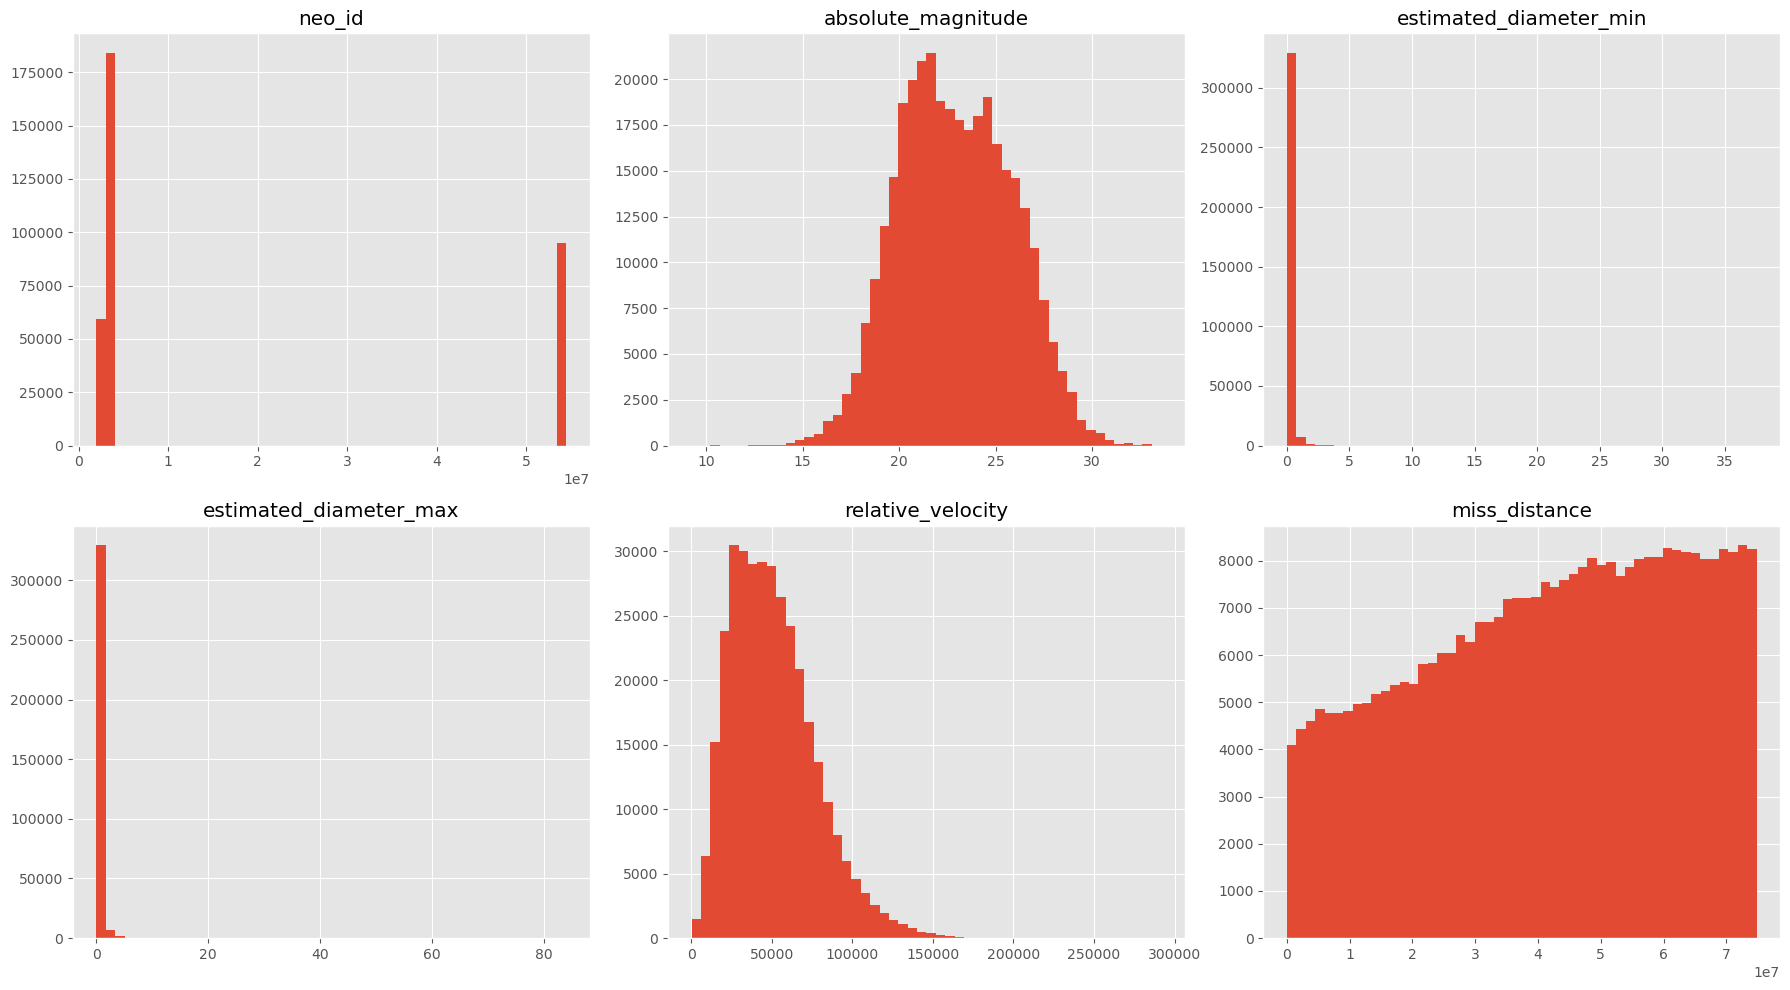

In [11]:
# Create a list to store the numeric columns
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

# Calculate the number of rows and columns needed for the subplots
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

# Plot histograms for numeric columns
for i, col in enumerate(numeric_cols):
    df[col].hist(ax=axes[i], bins=50)
    axes[i].set_title(col)
    axes[i].set_xlabel('')

# Remove any unused subplots
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Outliers

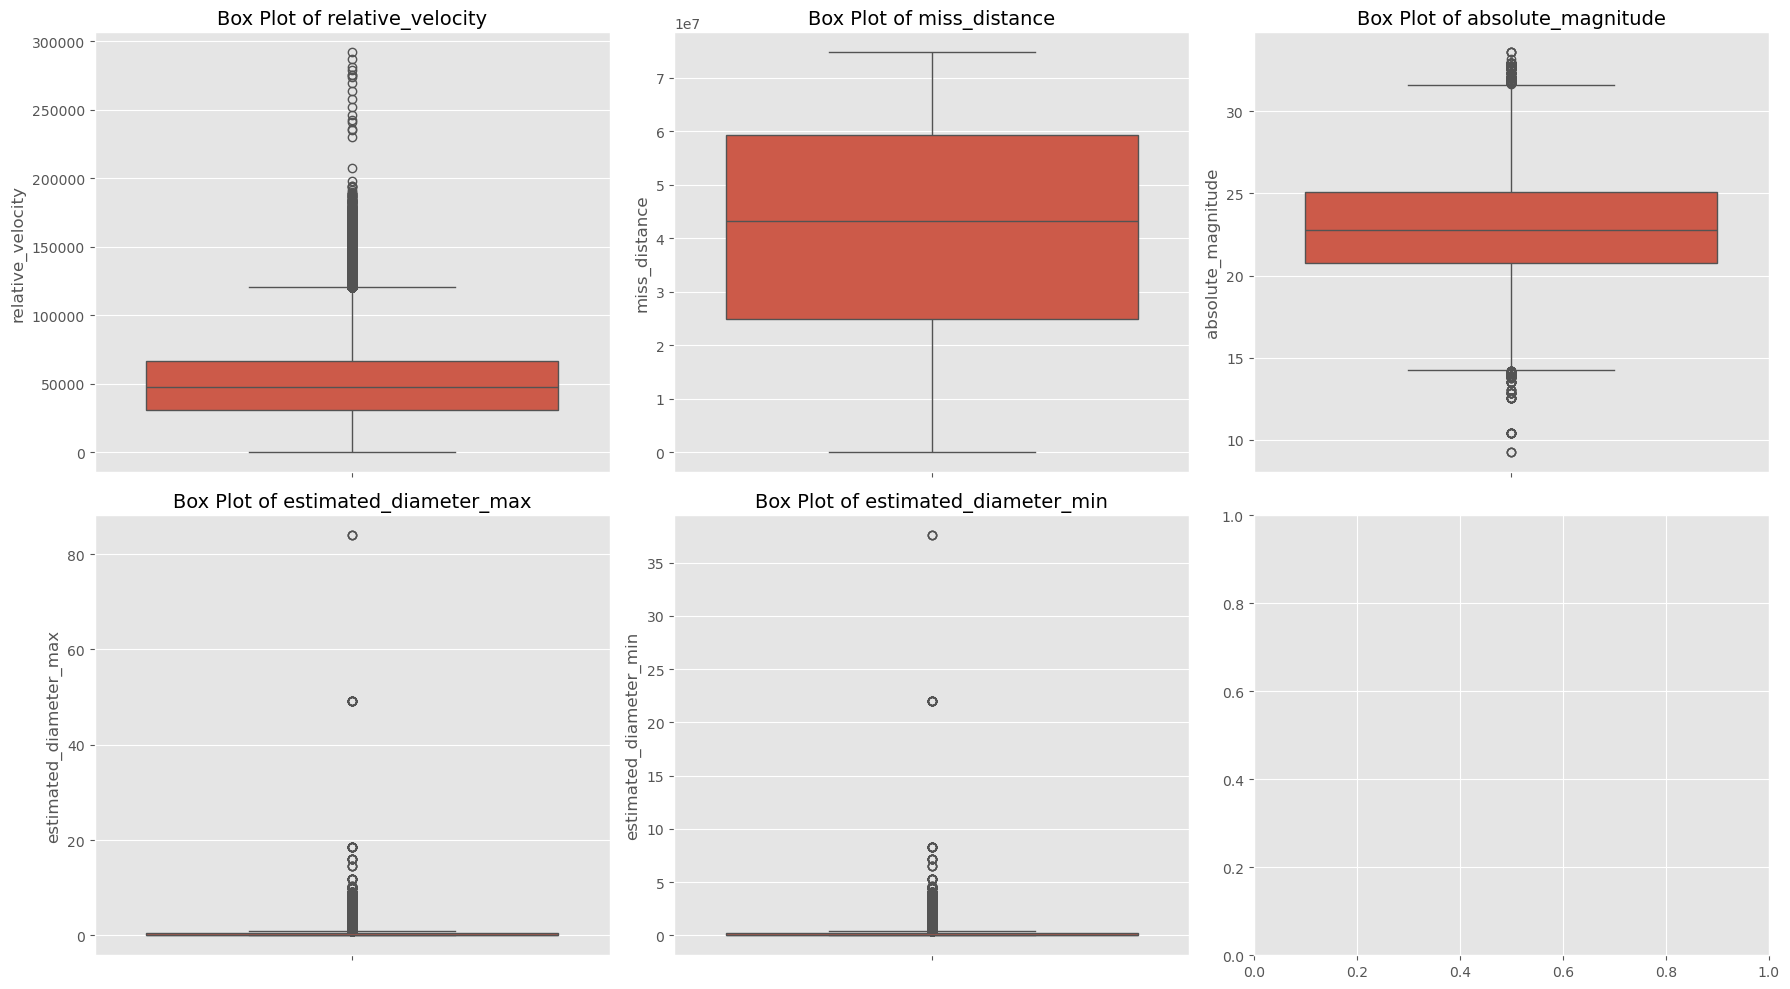

In [12]:
# Detecting outliers in our data
columns_to_plot = ['relative_velocity', 'miss_distance', 'absolute_magnitude' ,'estimated_diameter_max' , 'estimated_diameter_min']
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # Create subplots
axes = axes.flatten()
# Loop through the columns and plot each box plot in a subplot
for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}', fontsize=14)

plt.tight_layout()
plt.show()

# Removing outliers Using IQR

In [13]:
# Removing outliers
def remove_outliers(df):
    # Get all numeric columns
    numeric_columns = df.select_dtypes(include='number').columns
    new_df = df.copy()
    
    # Loop through each numeric column
    for col in numeric_columns:
        q1 = new_df[col].quantile(0.25)  
        q3 = new_df[col].quantile(0.75)  
        IQR = q3 - q1  
        lower_limit = q1 - (IQR * 1.5)
        upper_limit = q3 + (IQR * 1.5)
        
        
        new_df = new_df[(new_df[col] > lower_limit) & (new_df[col] < upper_limit)]
    
    return new_df

df = remove_outliers(df)


# Exploratory Data Analysis (EDA) 📊

In [14]:
df.shape

(295768, 8)

In [15]:
# explore every columns

for col in df.columns :
    print(f'{col} : {df[col].nunique()}')
    print(f'{df[col].value_counts().nlargest(5).to_string(header = False)}')
    print('\n','-' * 10 , '\n')

neo_id : 30035
2277810     211
2469219     197
3678630     192
3771633     186
54353620    169

 ---------- 

name : 30035
277810 (2006 FV35)               211
469219 Kamo`oalewa (2016 HO3)    197
(2014 OL339)                     192
(2017 FZ2)                       186
(2023 FW13)                      169

 ---------- 

absolute_magnitude : 1313
24.4    2196
26.1    2083
24.6    2079
25.5    2042
24.8    2037

 ---------- 

estimated_diameter_min : 1313
0.035039    2196
0.016016    2083
0.031956    2079
0.021113    2042
0.029144    2037

 ---------- 

estimated_diameter_max : 1313
0.078350    2196
0.035813    2083
0.071456    2079
0.047211    2042
0.065169    2037

 ---------- 

relative_velocity : 295763
58574.370714    2
53011.456338    2
53405.536383    2
57139.219620    2
51964.058408    2

 ---------- 

miss_distance : 295453
1.166241e+07    2
3.436250e+07    2
4.576415e+07    2
7.365992e+07    2
1.603521e+07    2

 ---------- 

is_hazardous : 2
False    263579
True      32189

 

In [16]:
# summary statistics
print(df.describe())

             neo_id  absolute_magnitude  estimated_diameter_min  \
count  2.957680e+05       295768.000000           295768.000000   
mean   1.926521e+07           23.548486                0.089345   
std    2.351526e+07            2.493745                0.084844   
min    2.002340e+06           19.420000                0.001266   
25%    3.545973e+06           21.450000                0.022108   
50%    3.763621e+06           23.360000                0.056566   
75%    5.410425e+07           25.400000                0.136319   
max    5.446281e+07           31.610000                0.347180   

       estimated_diameter_max  relative_velocity  miss_distance  
count           295768.000000      295768.000000   2.957680e+05  
mean                 0.199782       47635.923929   4.054848e+07  
std                  0.189717       22971.416222   2.094713e+07  
min                  0.002832         203.346433   6.745533e+03  
25%                  0.049436       29345.053103   2.352594e+07  


In [17]:
print()
print(df.describe(include = "object"))


                      name
count               295768
unique               30035
top     277810 (2006 FV35)
freq                   211


In [18]:
df.dtypes

neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

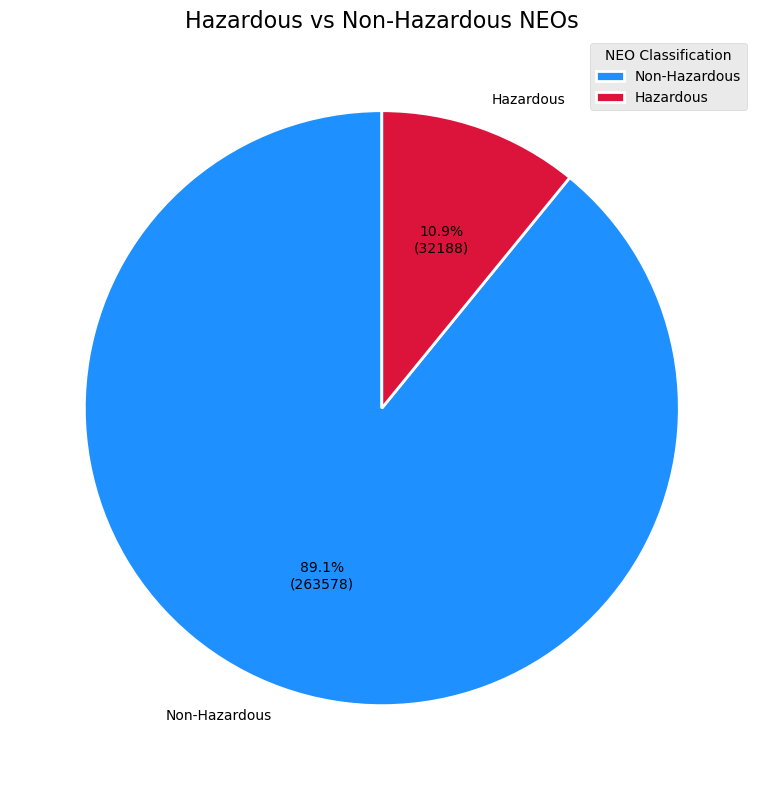

In [59]:
class_counts = df['is_hazardous'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(class_counts, 
        labels=['Non-Hazardous', 'Hazardous'], 
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(class_counts))})',
        startangle=90, 
        colors=['dodgerblue', 'crimson'],
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})
plt.title('Hazardous vs Non-Hazardous NEOs', fontsize=16)
plt.legend(title="NEO Classification")
plt.tight_layout()
plt.show()


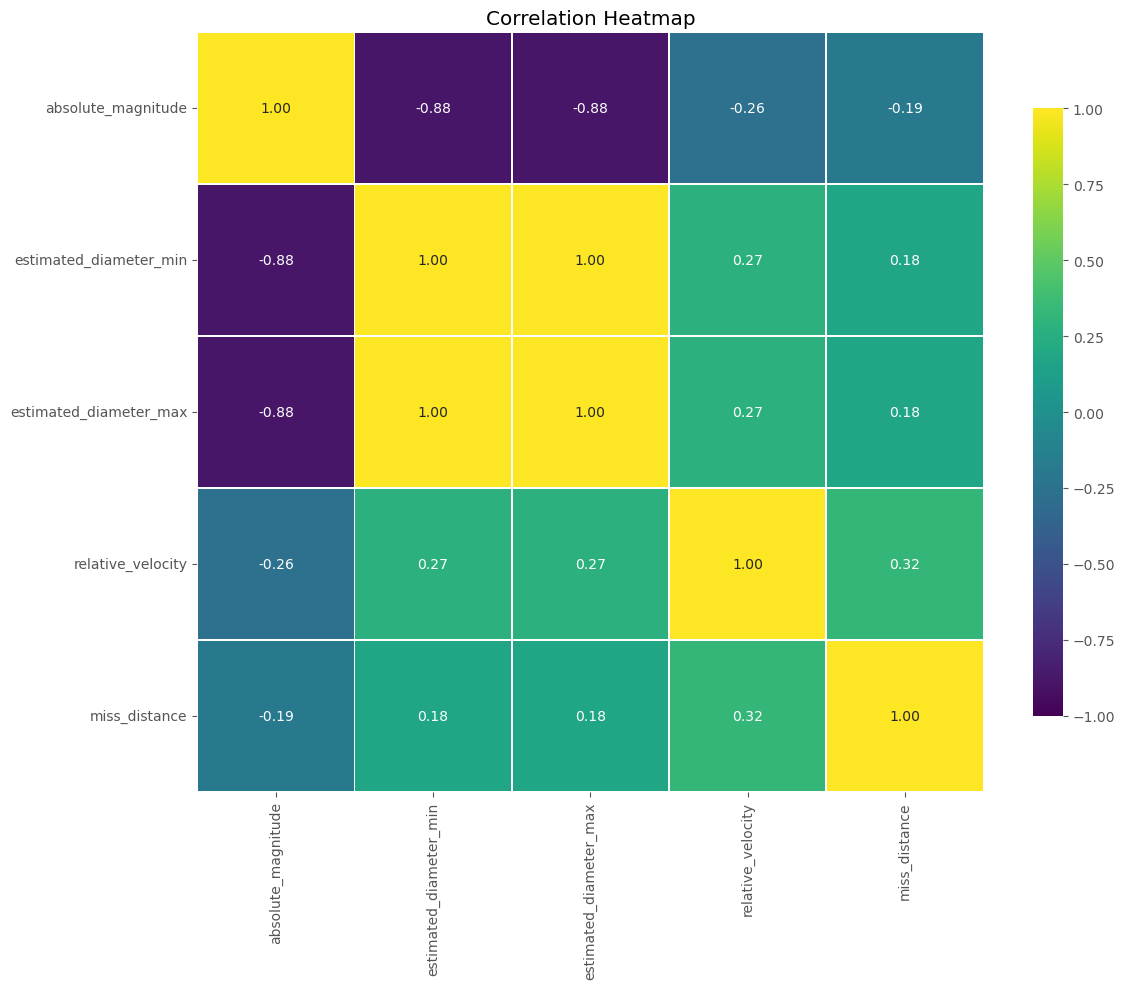

In [45]:
# Correlation heatmap
df_numeric = df.select_dtypes(include=['float'])  # Filter Numeric Columns
plt.figure(figsize=(12,10))
corr = df_numeric.corr()
sns.heatmap(data=corr, annot=True, cmap='viridis', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


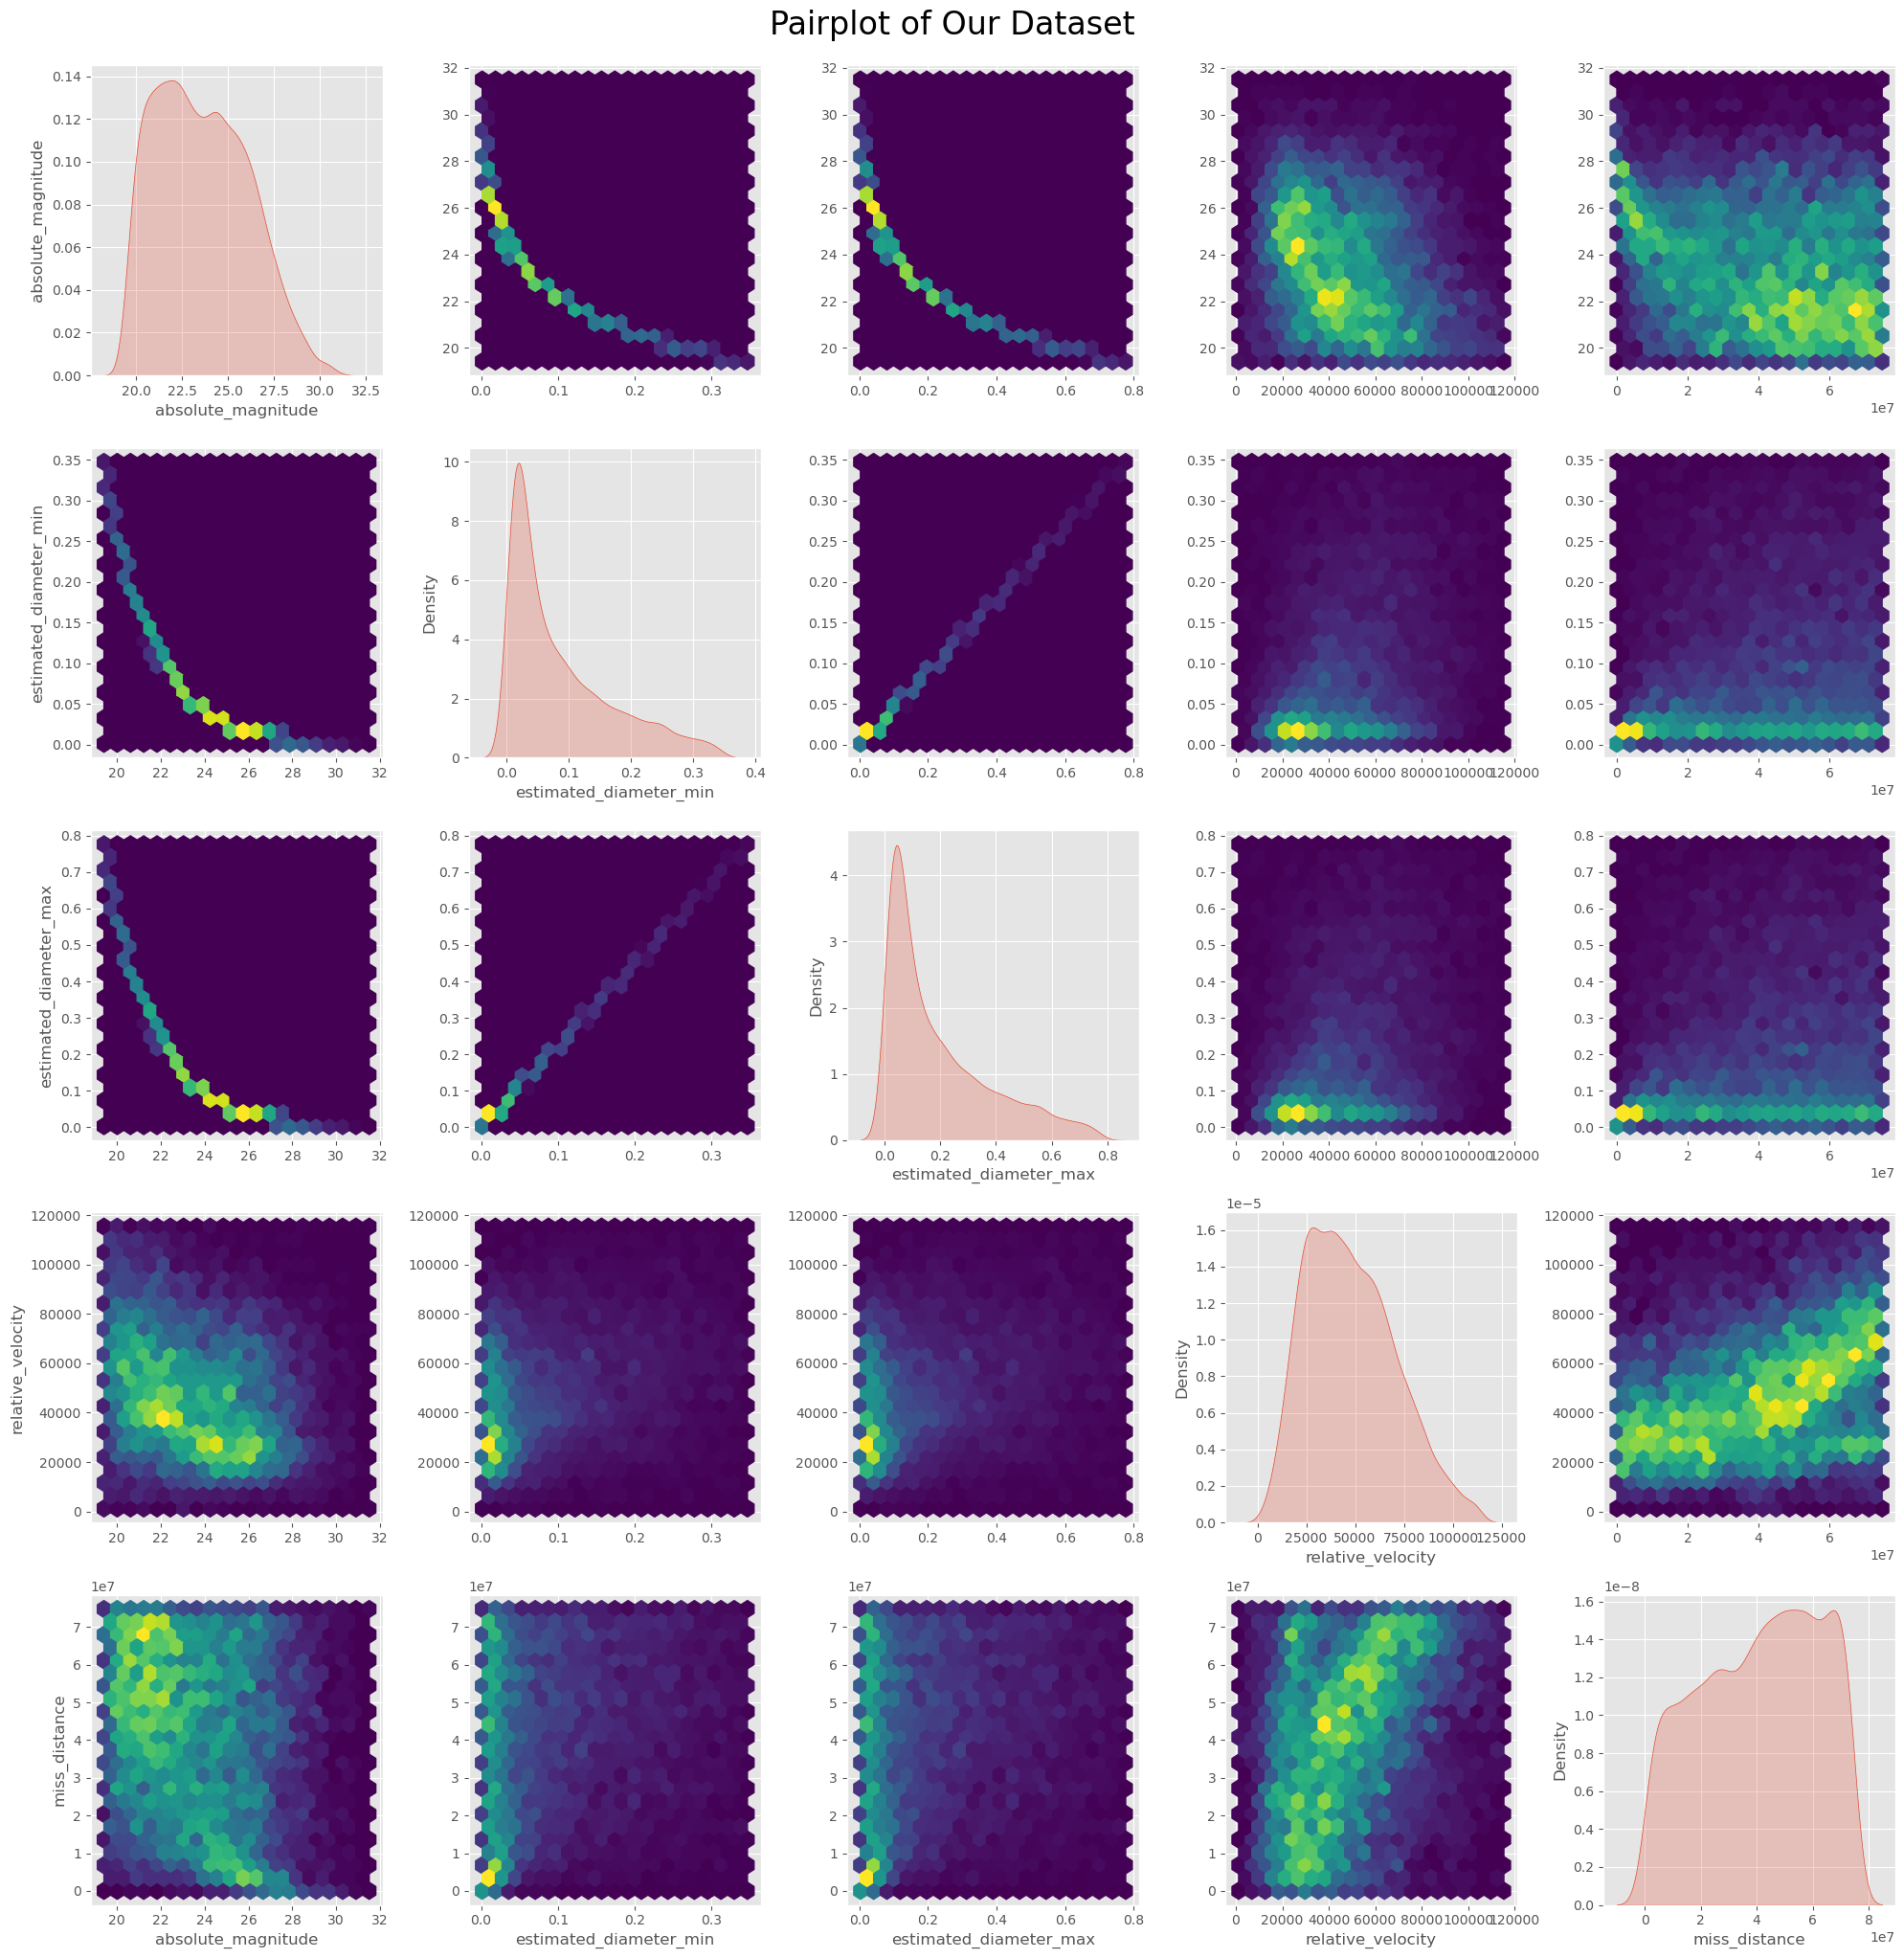

In [65]:

sample_size = min(10000, len(df))
columns_to_plot = df.drop(['neo_id', 'name', 'is_hazardous'], axis=1).sample(n=sample_size, random_state=42)
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Pairplot of Our Dataset', fontsize=24, y=1.02)

for i, col1 in enumerate(columns_to_plot.columns):
    for j, col2 in enumerate(columns_to_plot.columns):
        ax = axes[i, j]
        if i != j:
            ax.hexbin(columns_to_plot[col2], columns_to_plot[col1], gridsize=20, cmap='viridis')  
        else:
            sns.kdeplot(data=columns_to_plot[col1], ax=ax, shade=True)
        if i == len(columns_to_plot.columns) - 1:
            ax.set_xlabel(col2)
        if j == 0:
            ax.set_ylabel(col1)

plt.tight_layout()
plt.show()

# Data PreProcessing

## encoding categorical variables

In [22]:
le = LabelEncoder()
df['is_hazardous'] = le.fit_transform(df['is_hazardous'])
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,24865.506798,6.720689e+07,0
3,3132126,(2002 PB),20.63,0.198863,0.444672,78890.076805,3.039644e+07,0
4,3557844,(2011 DW),22.70,0.076658,0.171412,56036.519484,6.311863e+07,0
5,3656926,(2014 BT8),25.00,0.026580,0.059435,47477.649832,4.290521e+07,0
6,3421513,(2008 OX1),21.50,0.133216,0.297879,57853.295346,2.727908e+07,1


# Features Selection

In [60]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
correlation_threshold = 0.1
correlated_features = correlation_matrix['is_hazardous'][abs(correlation_matrix['is_hazardous']) > correlation_threshold].index.tolist()
if 'is_hazardous' in correlated_features:
    correlated_features.remove('is_hazardous')
    
X_numeric = df.select_dtypes(include=[np.number]).drop(['is_hazardous', 'neo_id'], axis=1)
mi_scores = mutual_info_classif(X_numeric, df['is_hazardous'])
mi_scores = pd.Series(mi_scores, index=X_numeric.columns)

k = 4    # Select top 4 features based on mutual information 
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_numeric, df['is_hazardous'])
mi_selected_features = X_numeric.columns[selector.get_support()].tolist()

selected_features = list(set(correlated_features + mi_selected_features)) # Combine features from both methods
print("Selected features:", selected_features)

Selected features: ['estimated_diameter_min', 'estimated_diameter_max', 'neo_id', 'absolute_magnitude', 'relative_velocity']


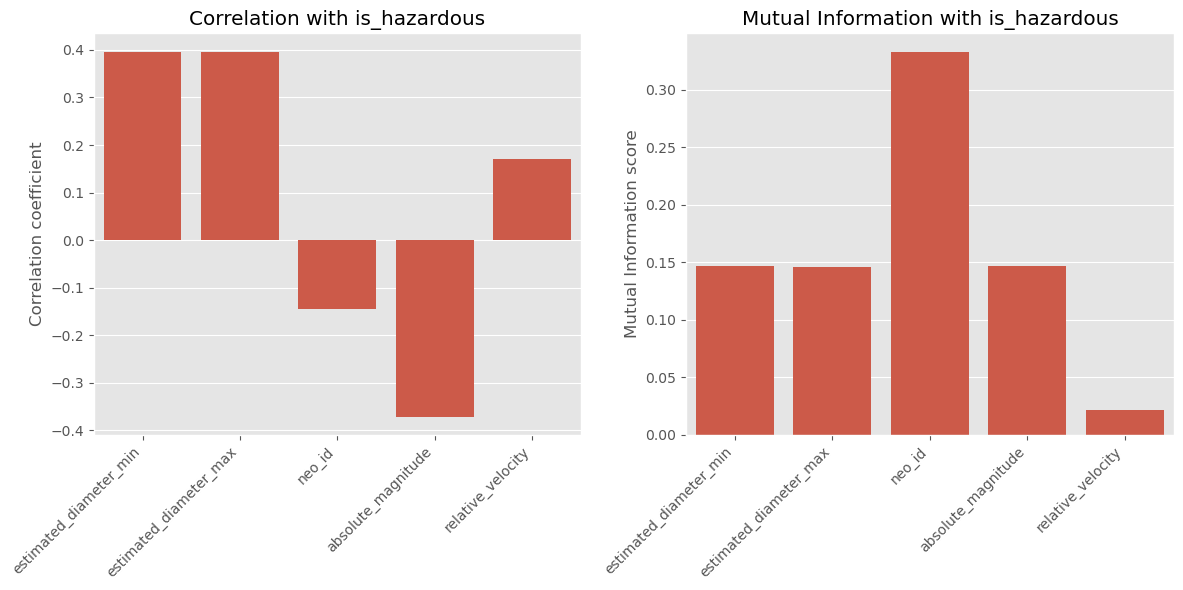

In [31]:
plt.figure(figsize=(12, 6))

# Plot correlation scores
plt.subplot(1, 2, 1)
sns.barplot(x=selected_features, y=correlation_matrix['is_hazardous'][selected_features])
plt.title('Correlation with is_hazardous')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation coefficient')

# Calculate and plot mutual information scores
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)

plt.subplot(1, 2, 2)
sns.barplot(x=selected_features, y=mi_scores[selected_features])
plt.title('Mutual Information with is_hazardous')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mutual Information score')

plt.tight_layout()
plt.show()

# Handle imbalanced data problem

Initial class distribution:
is_hazardous
0    0.891168
1    0.108832
Name: proportion, dtype: float64

Resampled class distribution:
is_hazardous
0    0.588235
1    0.411765
Name: proportion, dtype: float64

Shape of training set: (256047, 5)
Shape of testing set: (64012, 5)

Model Performance:

Random Forest:
Precision: 0.9908
Recall: 0.9924
F1-Score: 0.9916
AUC-ROC: 0.9996
CV F1-Score: 0.9891

Gradient Boosting:
Precision: 0.7636
Recall: 0.9815
F1-Score: 0.8589
AUC-ROC: 0.9345
CV F1-Score: 0.8590

Best performing model: Random Forest


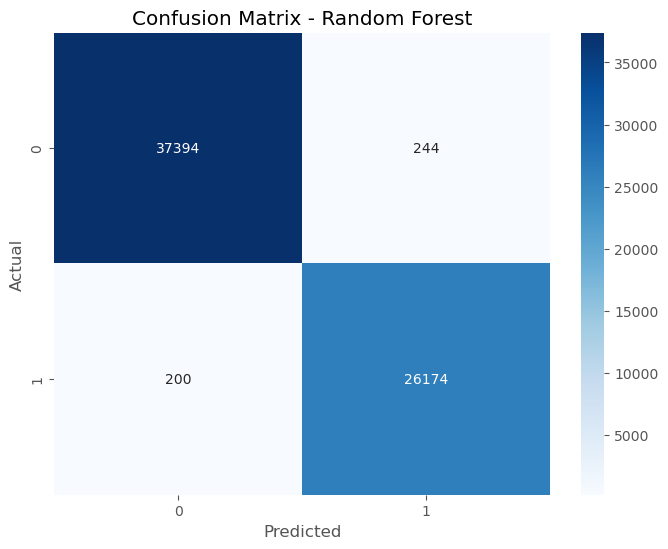

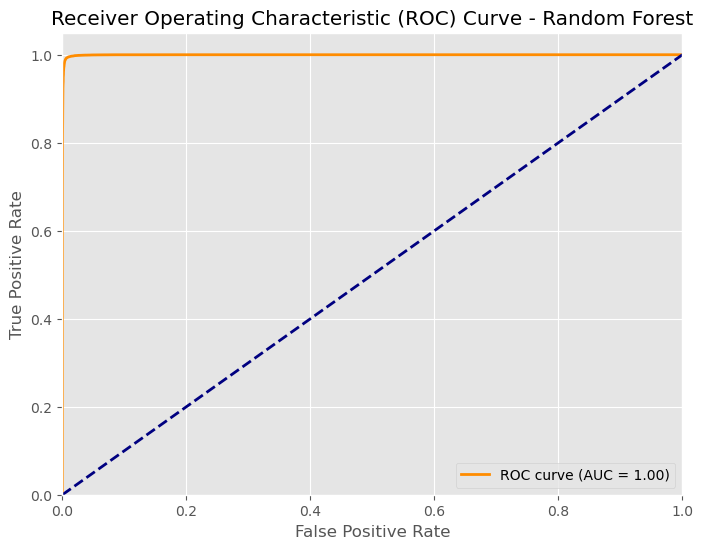

In [41]:
X = df[selected_features]  # Use selected features for modeling
y = df['is_hazardous']

print("Initial class distribution:")
print(y.value_counts(normalize=True))

# Create a resampling pipeline
resample_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),  # Increase minority class to 50% of majority
    ('undersampler', RandomUnderSampler(sampling_strategy=0.7, random_state=42))  # Reduce majority class
])

X_resampled, y_resampled = resample_pipeline.fit_resample(X, y) # Apply the resampling pipeline

print("\nDistribution after Resample:")
print(pd.Series(y_resampled).value_counts(normalize=True))

# Split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("\nShape of training set:", X_train.shape)
print("Shape of testing set:", X_test.shape)


# Build Our Models

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')  # cross-validation
    # Store results
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'CV F1-Score': cv_scores.mean()
    }

print("\nModel Performance:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Select the best model based on F1-Score
best_model = max(results, key=lambda x: results[x]['F1-Score'])
print(f"\nBest performing model: {best_model}")



# Confusion Matrix & ROC curve for the best model

In [ ]:
# Plot confusion matrix for the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve for the best model
y_pred_proba_best = best_model_instance.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - {best_model}')
plt.legend(loc="lower right")
plt.show()

In [67]:
# Save the cleaned dataset
cleaned_data_filename = 'cleaned_neo_data.csv'
df.to_csv(cleaned_data_filename, index=False)